In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
import pandas as pd
from scipy.signal import hilbert, chirp
import measures as nolds

In [3]:
def var(u_e):
    return np.var(u_e)

def freq(u_e):
    ind = argrelextrema(np.array(u_e), np.greater)
#     print(ind)
    diffs = np.diff(argrelextrema(np.array(u_e), np.greater))
#     print(diffs)
    n = int(len(diffs)/2)
    sub_ind = diffs[n-1:n+1]
    abso = np.absolute(sub_ind)
#   print(mean(abso), "here")
    #print(1/(0.01*mean(abso)))
    freq = 1/np.mean(abso)
    return 1/(0.01*np.mean(abso))
#TIME STEP IS SIZE 0.01

#print(freq(G[:,0]),freq(G[:,1]))

In [4]:
#FINAL ONE
#param
freq_x = []
freq_y = []
var_x =[]
z_list = list(np.arange(-3,0,0.05))
for z in z_list:
    #print(z)
    alpha = 3
    a = 0.7
    b = 0.8
    omega_sq = 1
    #model -> G[x,y]

    def model(G,t):
        return np.array([ alpha*(G[1] + G[0] - ((G[0]**3)/3) + z), -(1/alpha)*(G[0] - a + (b*G[1]) )])

    t = np.linspace(0, 100,  10000)              # time step
    G0 = np.array([0, 0])                     # initials conditions
    G = odeint(model, G0, t)

#     plt.show()
    freq_x.append(freq(G[:,0]))
    var_x.append(var(G[5000:,0]))
    freq_y.append(freq(G[:,1]))



/scinet/gpc/Applications/anaconda3/4.2.0_hub/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [5]:
#fixing the frequencies

freq_new = []

for i in range(len(z_list)):
    if var_x[i] < 0.1:
        freq_new.append(0)
    else:
        freq_new.append(freq_x[i])


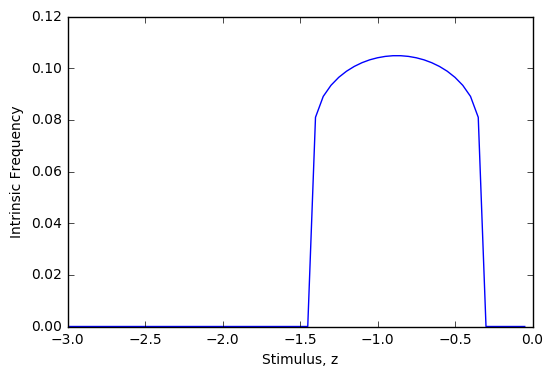

In [6]:
# #FINAL PLOT
plt.plot(z_list, freq_new)
plt.xlabel("Stimulus, z")
plt.ylabel("Intrinsic Frequency")
plt.show()
# freq_new

In [7]:
#dict of k:freq pairs
k_freq_dict = dict(zip(z_list, freq_new))
k_want =[]
freq_want=[]
for i in z_list:
    if k_freq_dict[i] >0 :
        k_want.append(i)
        freq_want.append(k_freq_dict[i])

In [8]:
#appendng 0 freq
k_want.append(z_list[31])
freq_want.append(freq_new[31])

In [9]:
#GETTING THE VALUES FOR K1 AND K2
table = [k_want, freq_want]


k1_col = []
k1freq = []
k2_col = []
k2freq = []
perc_diff = []

k_freq = np.transpose(table)
k_freq
num_k_vals = np.shape(k_freq)[0] #num of rows

#k_freq is a 12x2 array with k values in first column and the corresponding freq in second, it contains the subset of k that 
#actually result in oscillations

for i in range(num_k_vals):
    for j in range(i,num_k_vals):
        #appending the k1 value from the ith row in the first column of k_freq
        k1_col.append(k_freq[:,0][i])
        #appending the k1 frequency from the ith row in the second column of k_freq
        k1freq.append(k_freq[:,1][i])
        k2_col.append(k_freq[:,0][j])
        k2freq.append(k_freq[:,1][j])
        
        #calculating the percent difference in frequencies
        perc = (1- (min(k_freq[j,1],k_freq[i,1])/max(k_freq[j,1],k_freq[i,1])))*100
        perc_diff.append(perc)

In [10]:
#converting to dataframe to see what data looks like
d = {'k1': k1_col, 'freq1': k1freq, 'k2': k2_col, 'freq2': k2freq, 'perc_diff': perc_diff}
df = pd.DataFrame(data=d)
df

df_sorted = df.sort_values(['k1', 'perc_diff'])
df_single = df_sorted.drop_duplicates('perc_diff')

df_single
df_single_new = df_single.reset_index()
final_df_numpy = df_single_new[1:16].values


In [11]:
df_single_new[1:16]

,index,freq1,freq2,k1,k2,perc_diff
1,0,0.080981,0.080981,-1.4,-1.40,0.000000
2,1,0.080981,0.089077,-1.4,-1.35,9.088674
3,2,0.080981,0.093371,-1.4,-1.30,13.269320
4,18,0.080981,0.096442,-1.4,-0.50,16.031673
5,3,0.080981,0.096455,-1.4,-1.25,16.042920
6,4,0.080981,0.098814,-1.4,-1.20,18.047200
7,16,0.080981,0.100660,-1.4,-0.60,19.549848
8,5,0.080981,0.100671,-1.4,-1.15,19.558846
9,15,0.080981,0.102110,-1.4,-0.65,20.692581
10,6,0.080981,0.102122,-1.4,-1.10,20.701578


In [12]:
# #fixing the perc diff values -- final_df_numpy
# df_numpy = df_final.values
arr_perc_diff = final_df_numpy[:,5] #saving the 5th column (the percent differences)


In [12]:
#PART 2, PLOTTING COUPLED OSCI
#The following code defines the "right hand side" of the system of equations (also known as a vector field). 

from scipy.integrate import odeint
import matplotlib.pyplot as plt

def vectorfield(w, t, p):
    """
    Defines the differential equations for the coupled spring-mass system.

    Arguments:
        w :  vector of the state variables:
                  w = [x1,y1,x2,y2]
        t :  time
        p :  vector of the parameters:
                  p = [alpha, k1, k2, c, b,a]
    """
    x1, y1, x2, y2 = w
    alpha, k1, k2, c, b, a = p

    # Create f = (x1',y1',x2',y2'):
    f = [ alpha*(y1 + x1 - ((x1**3)/3) + k1+ c*x2),
         -(1/alpha)*( x1- a + (b*y1)), 
         alpha*(y2 + x2 - ((x2**3)/3) + k2+ c*x1),
        -(1/alpha)*( x2- a + (b*y2))]
    
    return f

In [14]:
# Use ODEINT to solve the differential equations defined by the vector field
solution_list = [] #from this we can get time series for everything

freq_listx1 = []
freq_listx2 = []

var_listx1 = []
var_listx2 = []

x1ts_list = []
x2ts_list = []

c_list = np.linspace(0,1.5,150)

# freq_listy2 = []
# freq_listy1 = []
# var_listy1 = []
# var_listy2 = []

#for each row in final_df_numpy set the k1 and k2
for i in range(np.shape(final_df_numpy)[0]):
    k1 = final_df_numpy[i,2]
    k2 = final_df_numpy[i,3]
    
    for c in c_list:

        # Parameter values
        alpha = 3
        a = 0.7
        b = 0.8

        # Initial conditions
        x1 = 0.0
        y1 = 0.0
        x2 = 0.0
        y2 = 0.0

        # Pack up the parameters and initial conditions:
        p = [alpha, k1, k2, c, b, a]
        w0 = [x1, y1, x2, y2]
        t = np.linspace(0, 100,  10000)              # time step

        #Call the ODE solver.
        wsol = odeint(vectorfield, w0, t, args=(p,))
        
        x1= wsol[:,0]
        x2= wsol[:,2]
        

        solution_list.append(wsol)
        
        freq_listx1.append(freq(x1))
        freq_listx2.append(freq(x2))
        
        var_listx2.append(var(x2))
        var_listx1.append(var(x1))

        x1ts_list.append(x1)
        x2ts_list.append(x2)
        

#         y1= wsol[:,1]
#         y2= wsol[:,3]
#         freq_listy1.append(freq(y1))
#         freq_listy2.append(freq(y2))
#         var_listy2.append(var(y2))
#         var_listy1.append(var(y1))

In [15]:
num_runs = len(x1ts_list)

In [16]:
#data to use for the rest of the proj
# x axis - c_list
c_list = np.linspace(0,0.04,20)

#y_axis
arr_perc_diff = final_df_numpy[:,5]

print(len(c_list), len(arr_perc_diff))
print(num_runs, len(x1ts_list), len(c_list)*len(arr_perc_diff))

20 15
300 300 300


In [1]:
##CALCULATING THE R AGAIN BUT THIS WITH A DIFFERENT TECHNIQUE

## testing
#len(x1ts_list)
# signal = x1ts_list[0]
# analytic_signal = hilbert(x1ts_list[0])
# amplitude_envelope = np.abs(analytic_signal)
# instantaneous_phase = np.unwrap(np.angle(analytic_signal))
# np.shape(instantaneous_phase)
# plt.plot(instantaneous_phase)
# plt.show()

#CALCULATING
new_phase_list = []

for i in range(num_runs):
    #print(i)
    signal1 = x1ts_list[i]
    signal2 = x2ts_list[i]

    analytic_signal1 = hilbert(signal1)
    analytic_signal2 = hilbert(signal2)

    instantaneous_phase1 = np.unwrap(np.angle(analytic_signal1))
    instantaneous_phase2 = np.unwrap(np.angle(analytic_signal2))
    
    diff = instantaneous_phase1 - instantaneous_phase2
    r = np.abs(np.sum(np.exp(1j*diff))/len(signal1))
    
    new_phase_list.append(r)
    
# PLOTTING
x=c_list
y=arr_perc_diff #this is the last column - list of percent differences (15 of them)
z=np.array(new_phase_list)

x=np.unique(x)
y=np.unique(y)
X,Y = np.meshgrid(x,y)

Z= z.reshape(len(y),len(x))

# plt.pcolormesh(X,Y,Z,edgecolor='k')
plt.pcolormesh(X,Y,Z)
plt.xlabel('Symmetric Coupling Strength, c')
plt.ylabel('Intrinsic Frequency Difference (%)')
plt.title('Phase Coherence Index, R')
plt.colorbar()
plt.show()

NameError: name 'num_runs' is not defined

In [18]:
dim_x1 = []
dim_x2 = []

for i in range(98,148):
    print(i)
    dx1 = nolds.corr_dim(x1ts_list[i],5)
    dx2 = nolds.corr_dim(x2ts_list[i],5)
    
    dim_x1.append(dx1)
    dim_x2.append(dx2)

np.save('4dim_x10p04.npy', dim_x1)
np.save('4dim_x20p04.npy', dim_x2)

98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147


DIM x1


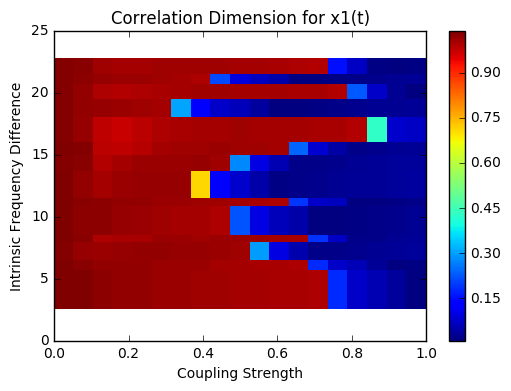

DIM x2


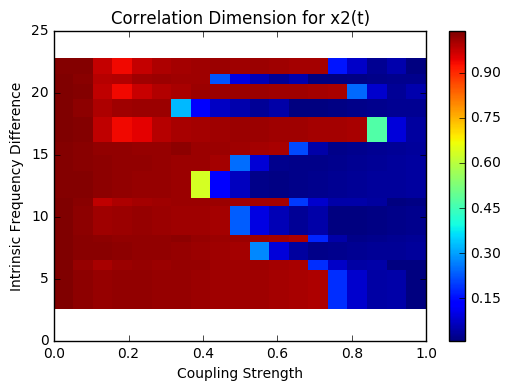

In [34]:
#PLOTTING DIM FOR X1
print("DIM x1")
x=c_list
y=perc_diff_list
z=np.array(dim_x1)

x=np.unique(x)
y=np.unique(y)
X,Y = np.meshgrid(x,y)

Z= z.reshape(len(y),len(x))

plt.pcolormesh(X,Y,Z)
plt.title("Correlation Dimension for x1(t)")
plt.xlabel('Coupling Strength')
plt.ylabel('Intrinsic Frequency Difference')
plt.colorbar()

plt.show()

#PLOTTING LYAP FOR X2
print("DIM x2")

x=c_list
y=perc_diff_list
z=np.array(dim_x2)

x=np.unique(x)
y=np.unique(y)
X,Y = np.meshgrid(x,y)

Z= z.reshape(len(y),len(x))

plt.pcolormesh(X,Y,Z)
plt.title("Correlation Dimension for x2(t)")
plt.xlabel('Coupling Strength')
plt.ylabel('Intrinsic Frequency Difference')
plt.colorbar()

plt.show()